In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import re
import collections
import glob
import pandas as pd
from itertools import islice
from transformers import DistilBertModel, DistilBertTokenizer, logging
from itertools import chain
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report


import sys
import time
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

from build_features import similarity_matrix, name_cleaner, yield_chunks, text_cleaner
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify
logging.set_verbosity_error()

%matplotlib inline

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- T

In [2]:
model = loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

CPU Success


# Data Analysis

In [2]:
from urllib.parse import urlsplit
from matplotlib.patches import ConnectionPatch
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter
import pandas as pd
import numpy as np

In [4]:
test_agro = pickle.load(open('../data/processed/testing_web_trees_agroforestry.pkl', 'rb'))
test_llifle = pickle.load(open('../data/processed/testing_web_trees_llifle.pkl', 'rb'))

data = dict(test_agro) 
data.update(test_llifle)

# Undict the data
external_data = (list(chain.from_iterable(data.values())))

In [ ]:
# Init emmty_list:
uncertain_list = []
# Arrays for plotting
yhat = np.array([]).reshape(0, 2)
y_onecold = np.array([])
# Sentence list
sentence_list = []

# loop over the values of the list
for (label, span) in tqdm_notebook(external_data):
    # Clean the sentence
    sentences = text_cleaner(span)
    # Loop over the sentences
    for sent in sentences:
        # Store for plotting
        sentence_list.append((label, sent))
        # Get predictions
        (pred_label, pred_value) = classify(sent, model=model, pred_values=True)
        # Store for plotting
        yhat = np.vstack([yhat, pred_value.numpy()])
        y_onecold = np.hstack([y_onecold, label])
        # Detach
        pred_value = pred_value[1].numpy().item()
        if  0.45 < pred_value < 0.55:
            # Append to list
            uncertain_list.append((label, pred_label, pred_value, sent))

uncertain_list = list(set(uncertain_list))     

In [ ]:
with open('../data/processed/external_sentence_list.pkl', 'wb') as f:
    pickle.dump(sentence_list, f)
with open('../data/processed/external_uncertain_sentences.pkl', 'wb') as f:
    pickle.dump(uncertain_list, f)
with open('../data/processed/external_yhat.pkl', 'wb') as f:
    pickle.dump(yhat, f)
with open('../data/processed/external_y_onecold.pkl', 'wb') as f:
    pickle.dump(y_onecold, f)

In [3]:
sentence_list = pickle.load(open('../data/processed/external_sentence_list.pkl', 'rb'))
uncertain_list = pickle.load(open('../data/processed/external_uncertain_sentences.pkl', 'rb'))
yhat = pickle.load(open('../data/processed/external_yhat.pkl', 'rb'))
y_onecold = pickle.load(open('../data/processed/external_y_onecold.pkl', 'rb'))

In [4]:
# Correct for beta
y_onecold_corrected = np.array([])
changed = 0
pred_list = []
for label, prediction in zip(tqdm(y_onecold), yhat):
    if prediction[1] >= .8:
        y_onecold_corrected = np.hstack([y_onecold_corrected, 1])
        changed += 1
    else:
        y_onecold_corrected = np.hstack([y_onecold_corrected, label])

100%|██████████████████████████████████| 74836/74836 [00:01<00:00, 54083.58it/s]


In [9]:
print(classification_report(y_onecold_corrected, yhat[:, 1] >= .5, digits=5, target_names=['Other', 'Descriptions']))

              precision    recall  f1-score   support

       Other    0.96436   0.97577   0.97003     64639
Descriptions    0.83397   0.77140   0.80147     10197

    accuracy                        0.94793     74836
   macro avg    0.89916   0.87359   0.88575     74836
weighted avg    0.94659   0.94793   0.94706     74836



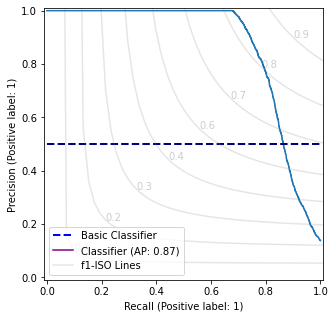

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
display = PrecisionRecallDisplay.from_predictions(y_onecold_corrected, yhat[:, 1], name="Description Text Classifier", ax=ax)
#_ = display.ax_.set_title("2-class Precision-Recall Curve")
#display.plot(ax=ax)
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.plot([0, 1], [0.5, 0.5], color='navy', lw=2, linestyle='--', label='Basic Classifier')

legend_elements = [Line2D([0], [0], color='b', lw=2, label='Basic Classifier', linestyle='--'),
                   Line2D([0], [0], color='purple', label=f'Classifier (AP: {display.average_precision:.2f})'),
                   Line2D([0], [0], color='grey', alpha=0.2, label='f1-ISO Lines')]

ax.legend(handles=legend_elements, loc='lower left')


f_scores = np.linspace(0.1, .9, num=8)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1.01)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    ax.annotate("{0:0.1f}".format(f_score), xy=(f_score, f_score)).set_alpha(.2)


#ax.set_title("2-class Precision-Recall Curve")
#fig.savefig('precision_recall_plot_extern.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [8]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y_onecold_corrected, yhat[:, 1])
metrics.auc(fpr, tpr)


0.9313769889597522

In [9]:
# Reshape values
y_onecold_reshaped = np.reshape(y_onecold, (-1, 1))
y_all = np.hstack((yhat, y_onecold_reshaped))

In [10]:
sns.set_style('whitegrid')

Text(0.46, 0.07, 'Prediction Value')

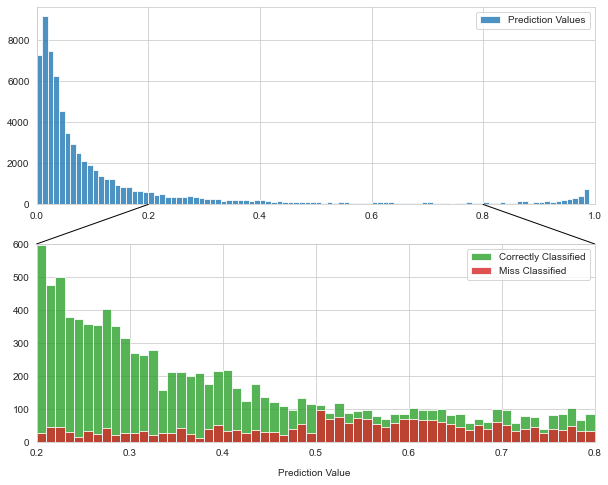

In [11]:
fig, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False, figsize=(10, 8))

ax1.hist( y_all[:, 1], 
          bins=np.arange(0, 1, 0.01), histtype='bar', align='mid',
          width=0.01, stacked=False, alpha=0.8)
ax1.legend(loc='upper right', labels=['Prediction Values'])
ax1.set_xlim([0, 1])
ax2.hist( [y_all[:, 1],
           y_all[(y_all[:, 1] < 0.5) & (y_all[:, 1] >= 0.2) & (y_all[:, 2] == 1) | 
                  (y_all[:, 1] > 0.5) & (y_all[:, 1] <= 0.8) & (y_all[:, 2] == 0), 1]],
           #y_all[(y_all[:, 1] > 0.5) & (y_all[:, 1] <= 0.8) & (y_all[:, 2] == 0), 1]], 
          bins=np.arange(0.2, .8, 0.01), histtype='bar', align='left',
          width=0.01, stacked=False, alpha=0.8, rwidth=0, color=[u'#2ca02c', u'#d62728'])

ax2.legend(loc='upper right', labels=['Correctly Classified', 'Miss Classified'])
ax2.set_xlim([0.2, .8])
ax2.set_ylim([0, 600])
con1 = ConnectionPatch(xyA=(0.2, 600), xyB=(0.2, -0.1), coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color="black")
ax2.add_artist(con1)
con2 = ConnectionPatch(xyA=(0.8, 600), xyB=(0.8, -0.1), coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color="black")
ax2.add_artist(con2)
#fig.text(.07, 0.5, 'Count', va='center', rotation='vertical')
fig.text(.46, 0.07, 'Prediction Value', va='center', rotation='horizontal')

#fig.savefig('predictionvalues_external.pdf', format='pdf', dpi=1200, bbox_inches='tight')

<AxesSubplot:>

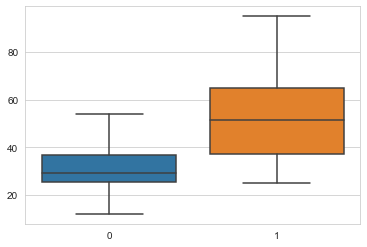

In [12]:
x = y_all[(y_all[:, 1] < 0.5) & (y_all[:, 1] >= 0.2) & (y_all[:, 2] == 1), 1]
bins_x = np.digitize(x, np.arange(0., 1, 0.01))
y = y_all[(y_all[:, 1] > 0.5) & (y_all[:, 1] <= 0.8) & (y_all[:, 2] == 0), 1]
bins_y = np.digitize(y, np.arange(0., 1, 0.01))
unique, counts_x = np.unique(bins_x, return_counts=True)
unique, counts_y = np.unique(bins_y, return_counts=True)
sns.boxplot(data=[counts_x, counts_y])

In [13]:
y_all.shape

(74836, 3)

In [14]:
(y_all[:, 1] > 0.5) & (y_all[:, 2] == 1)

array([False, False, False, ..., False, False, False])

In [15]:
# Correct
correct = y_all[(y_all[:, 1] > 0.5) & (y_all[:, 2] == 1) | (y_all[:, 1] < 0.5) & (y_all[:, 2] == 0), 1]
incorrect = y_all[(y_all[:, 1] < 0.5) & (y_all[:, 2] == 1) | (y_all[:, 1] > 0.5) & (y_all[:, 2] == 0), 1]

In [16]:
df = pd.DataFrame({'Probability_0': y_all[:, 0], 'Probability_1': y_all[:, 1], 'Label': y_all[:, 2]})

In [17]:
def get_correctness(row):
    if row['Probability_1'] <= 0.2:
        val = 'Correct'
    elif row['Probability_1'] >= 0.8:
        val = 'Correct'
    elif row['Probability_0'] >= 0.5 and row['Label'] == 0:
        val = 'Correct'
    elif row['Probability_1'] >= 0.5 and row['Label'] == 1:
        val = 'Correct'
    else:
        val = 'Incorrect'

    return val

In [18]:
df['Correct'] = df.apply(get_correctness, axis=1)

In [19]:
df

,Probability_0,Probability_1,Label,Correct
0,0.927281,0.072719,0.0,Correct
1,0.961438,0.038562,0.0,Correct
2,0.965965,0.034035,0.0,Correct
3,0.984558,0.015442,0.0,Correct
4,0.997322,0.002678,0.0,Correct
...,...,...,...,...
74831,0.941946,0.058054,0.0,Correct
74832,0.896700,0.103300,0.0,Correct
74833,0.652206,0.347793,0.0,Correct
74834,0.936922,0.063077,0.0,Correct


In [20]:
def calculate_ticks(ax, ticks, round_to=0.1, center=False):
    upperbound = np.ceil(ax.get_ybound()[1]/round_to)
    lowerbound = np.floor(ax.get_ybound()[0]/round_to)
    dy = upperbound - lowerbound
    fit = np.floor(dy/(ticks - 1)) + 1
    dy_new = (ticks - 1)*fit
    if center:
        offset = np.floor((dy_new - dy)/2)
        lowerbound = lowerbound - offset
    values = np.linspace(lowerbound, lowerbound + dy_new, ticks)
    return values*round_to


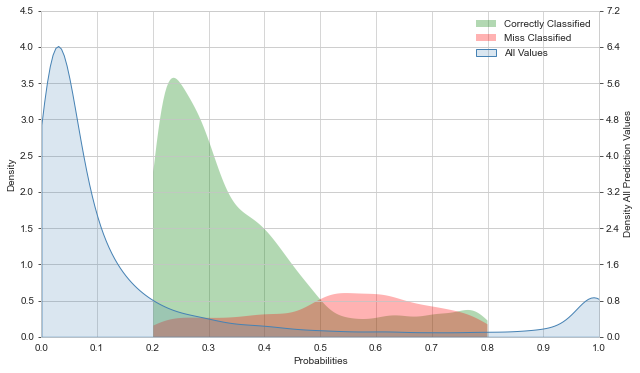

In [21]:
fig, (ax1) = plt.subplots(1, figsize=(10, 6))

sns.kdeplot(data=df[(df['Probability_1'] > 0.2) & (df['Probability_1'] < 0.8)] , x="Probability_1", hue="Correct", bw_adjust=1, cut=0, ax=ax1,
           fill=True, common_norm=True, alpha=0.3, linewidth=0, palette=['red', 'green'])
           #multiple="fill")
    
ax2 = ax1.twinx()

sns.kdeplot(data=df, x="Probability_1", ax=ax2, fill=True, color='steelblue', alpha=0.2, linewidth=1,
           cut=0, bw_adjust=1)
           #multiple="fill"

#ax1.set_yticks(np.linspace(0, 3.5, num=8))
#ax2.set_yticks(np.linspace(0, 6.5, num=18))


#ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1]+1, 6.2))
#ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1]+1, 6.2))

ax1.set_yticks(calculate_ticks(ax1, 10))
ax2.set_yticks(calculate_ticks(ax2, 10))

ax1.set_xticks(np.linspace(0, 1, num=11))
ax2.set_xlim([0.0, 1])
#ax2.axes.get_yaxis().set_visible(False)
ax1.set_xlabel('Probabilities')
ax2.set_ylabel('Density All Prediction Values')
#ax1.legend(loc='upper right', labels=['Correctly Classified', 'Miss Classified'])

ax1.legend(bbox_to_anchor= (1, 1), labels=['Correctly Classified', 'Miss Classified'], frameon=False)
ax2.legend(bbox_to_anchor= (0.925, 0.91), labels=['All Values'], frameon=False)

#fig.savefig('predictionvalues_external.pdf', format='pdf', dpi=1200, bbox_inches='tight')

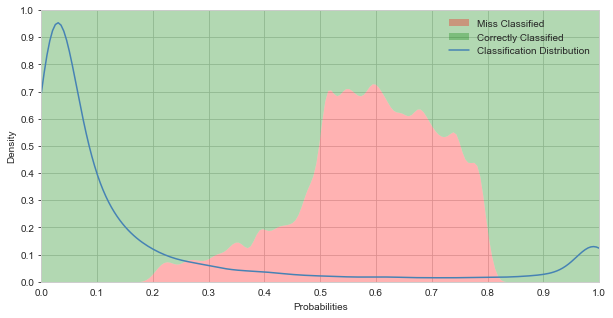

In [34]:
fig, (ax1) = plt.subplots(1, figsize=(10, 5))

sns.kdeplot(data=df , x="Probability_1", hue="Correct",
           fill=True, alpha=0.3, linewidth=0, palette=['green', 'red'], multiple="fill", 
            bw_adjust=0.35,
            ax=ax1)
    
    
ax2 = ax1.twinx()

sns.kdeplot(data=df, x="Probability_1", ax=ax2, fill=False, color='steelblue', alpha=0.8, linewidth=1.5,
           cut=0, bw_adjust=1)
           #multiple="fill"
    
#ax1.set_yticks(calculate_ticks(ax1, 10))
#ax2.set_yticks(calculate_ticks(ax2, 10))

ax1.set_xticks(np.linspace(0, 1, num=11))
ax1.set_yticks(np.linspace(0, 1, num=11))
ax2.set_xlim([0.0, 1])
#ax2.axes.get_yaxis().set_visible(False)
ax1.set_xlabel('Probabilities')
ax2.set_ylabel('Density All Prediction Values')
#ax1.legend(loc='upper right', labels=['Correctly Classified', 'Miss Classified'])
ax2.axes.get_yaxis().set_visible(False)

ax1.legend(bbox_to_anchor= (0.953, 1), labels=['Miss Classified', 'Correctly Classified'], frameon=False)
ax2.legend(bbox_to_anchor= (1., 0.9), labels=['Classification Distribution'], frameon=False)


fig.savefig('predictionvalues_external.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
traindata = pickle.load(open('../data/processed/COLAB.pkl', 'rb'))

In [ ]:
# Load the pickle list
datalist = glob.glob('../data/processed/train*.pkl')
# Init list
traindata_before = {}
# Loop over the pickles
for data in datalist:
    # Open the pickles
    datadict = pickle.load(open(data, 'rb'))
    # Update
    traindata_before.update(datadict)

In [ ]:
zeros_before = []
ones_before = []

for key in tqdm_notebook(traindata_before.keys()):
    for (label, chunk) in traindata_before[key]:
        if label == 0:
            zeros_before.append(len(chunk.split()))
        else:
            ones_before.append(len(chunk.split()))
            
zeros_before = np.array(zeros_before)
zeros_before = zeros_before[zeros_before>0]

ones_before = np.array(ones_before)
ones_before = ones_before[ones_before>0]

In [ ]:
zeros = []
ones = []

for (label, chunk) in tqdm_notebook(traindata):
    if label == 0:
        zeros.append(len(chunk.split()))
    else:
        ones.append(len(chunk.split()))



In [ ]:
zeros = np.array(zeros)
ones = np.array(ones)

zeros = np.array(zeros)
zeros = zeros[zeros>0]

ones = np.array(ones)
ones = ones[ones>0]

In [ ]:
sns.set_style('whitegrid')
fig, (ax_hist_BOW, ax_box_BOW,)  = plt.subplots(2, sharex=True,
                                                        gridspec_kw={"height_ratios": (.9, .1,)},
                                                       figsize=(5, 3))

logbins = np.logspace(np.log10(1),np.log10(1000), 25)
flierprops = dict(marker='.', markerfacecolor='black', markersize=5,
                  markeredgecolor='none')

plt.xlabel('Text Length')

sns.boxplot(zeros_before, ax=ax_box_BOW, showfliers=False,)
#sc = plt.scatter([1, 1], [zeros_before.min(), zeros_before.max()])

#ax_box_BOW.axis('off')
ax_hist_BOW.hist(zeros_before, 
         bins=logbins, histtype='bar', align='mid',
         #rwidth=0.9, stacked=False, alpha=0.8,
         zorder=3, edgecolor=None, )

ax_box_BOW.spines['right'].set_visible(False)
ax_box_BOW.spines['top'].set_visible(False)
ax_box_BOW.spines['left'].set_visible(False)
ax_box_BOW.spines['bottom'].set_visible(False)
ax_box_BOW.grid(False)

ax_box_BOW.set_xscale('log')
plt.xlabel('')
plt.setp([ax_hist_BOW, ], xlim=(1, 1000), ylim=(0, 250000))
#plt.tick_params(axis='y', which='both', labelsize=1) #labelsize=5 instead of labelsize=10
#ax_box_CUB.set_title('CUB')
plt.subplots_adjust(wspace=0, hspace=0.05)
ax_hist_BOW.title.set_text('Non-Description Text Length Before Splitting')

#sns.despine(ax=ax_box, left=True)
#fig.savefig('histogram_text_length_1.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
# Load the pickle list
datalist = glob.glob('../data/description/01_*PLANTS.pkl')
# Init list
URL_dict = {}
# Loop over the pickles
for data in datalist:
    # Open the pickles
    datadict = pickle.load(open(data, 'rb'))
    # Update
    URL_dict.update(datadict)

In [ ]:
# Load the pickle list
datalist = glob.glob('../data/description/02_*PLANTS.pkl')
# Init list
SENTS_dict = {}
# Loop over the pickles
for data in datalist:
    # Open the pickles
    datadict = pickle.load(open(data, 'rb'))
    # Update
    SENTS_dict.update(datadict)

In [ ]:
bases = []
counts_total = []
counts_unique = []
for key in tqdm_notebook(URL_dict.keys()):
    base = [urlsplit(URL).netloc for URL in URL_dict[key]]
    counts_total.append(len(base))
    counts_unique.append(len(list(set(base))))
    bases += base

In [ ]:
count_text = []

for key in tqdm_notebook(SENTS_dict.keys()):
    text = [chunk for part in SENTS_dict[key] for chunk in part]
    count_text.append(len(SENTS_dict[key]))

In [ ]:
counts_total = np.array(counts_total)
counts_total = counts_total[counts_total>0]

counts_unique = np.array(counts_unique)
counts_unique = counts_unique[counts_unique>0]

count_text = np.array(count_text)
count_text = count_text[count_text>0]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.set_style('whitegrid')
ax = sns.histplot(data=[counts_total, counts_unique, count_text], #log_scale=True) 
                  binwidth=1, kde=False, multiple="dodge", cbar=False)
plt.legend(loc='upper right', labels=['URLs with Text per Species', 'Unique Base URLs per Species', 'Unique URLs per Species', ])
#ax.set_title('Histogram')
plt.xlim(0, 70)
#fig.savefig('URL_distribution.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10, 4))
#fig.suptitle('Vertically stacked subplots')
ax1.hist([counts_total], 
              bins=np.arange(0, 60, 1), histtype='bar', align='mid',
              rwidth=1, stacked=False, alpha=0.8)
ax1.legend(loc='upper right', labels=['Number of Unique URLs per Species'])

#ax1.set_title("Unique URLs per Species")
ax2.hist([counts_unique], 
              bins=np.arange(0, 60, 1), histtype='bar', align='mid',
              rwidth=1, stacked=False, color='salmon', alpha=0.8)
ax2.legend(loc='upper right', labels=['Number of Unique Base URLs per Species'])

#ax2.set_title("Unique Base URLs per Species")
ax3.hist([count_text], 
              bins=np.arange(0, 60, 1), histtype='bar', align='mid',
              rwidth=1, stacked=False, color='green', alpha=0.6)
ax3.legend(loc='upper right', labels=['Number of URLs with Text per Species'])

#ax3.set_title("URLs with Text per Species")


plt.setp([ax1, ax2, ax3], xlim=(0, 60), ylim=(0, 2000))



for ax in fig.get_axes():
    ax.label_outer()
    
#fig.savefig('URL_distribution.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
sns.set_style('whitegrid')
fig, (ax, box)  = plt.subplots(2, sharex=True,
                               gridspec_kw={"height_ratios": (.9, .1,)},
                               figsize=(10, 2))

flierprops = dict(marker='.', markerfacecolor='black', markersize=5,
                  markeredgecolor='none')


sns.boxplot(count_text, ax=box, flierprops=flierprops, color='green')
#sc = plt.scatter([1, 1], [zeros_before.min(), zeros_before.max()])

#box.axis('off')
ax.hist(count_text, 
         bins=np.arange(0, 60, 1), histtype='bar', align='mid',
         #rwidth=0.9, stacked=False, alpha=0.8,
         zorder=3, edgecolor=None, color='green')

box.spines['right'].set_visible(False)
box.spines['top'].set_visible(False)
box.spines['left'].set_visible(False)
box.spines['bottom'].set_visible(False)
box.grid(False)


box.set_xticklabels(np.arange(0, 90, 10))
plt.setp([ax], xlim=(0, 90), ylim=(0, 2000))
plt.xlabel('')
#plt.setp([ax, ], xlim=(1, 1000), ylim=(0, 250000))
#plt.tick_params(axis='y', which='both', labelsize=1) #labelsize=5 instead of labelsize=10
#ax_box_CUB.set_title('CUB')
#plt.subplots_adjust(wspace=0, hspace=0.05)
#ax_hist_BOW.title.set_text('Non-Description Text Length Before Splitting')

#sns.despine(ax=ax_box, left=True)
fig.savefig('URL_distribution_3.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
URLs = Counter(bases)
URLs_sorted = {k: v for k, v in sorted(URLs.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
len(URLs_sorted.keys())

In [ ]:

data = []
other = 0
for idx, key in enumerate(list(URLs_sorted.keys())):
    if idx < 20:
        data.append(((key.lstrip('www.')), URLs_sorted[key]))
    else:
        other += URLs_sorted[key]
        
#data.append(('other', other))

In [ ]:
other

In [ ]:
df = pd.DataFrame(data, columns=['URL', 'Count'])
#df_melt = df.melt(df, id_vars=['URL'], value_vars=['Count'])

In [ ]:
df['Percentage'] = df['Count'] / (df['Count'].sum() + other) * 100
df['Cumsum'] = df['Percentage'].cumsum()

In [ ]:
df['Percentage'].values.sum()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.set_style('whitegrid')
#sns.set_theme(style="darkgrid")
ax = sns.barplot(y='Count', x="URL", data=df,
                color="salmon", saturation=.5)
ax.set_xticklabels(df['URL'], rotation=30, ha="right")
for p, value in zip(ax.patches, df['Percentage'].values):
    ax.annotate(f'{value:.2f}%', xy=(p.get_x()+p.get_width()/5, p.get_height()),
                ha='left', va='bottom', rotation=30, )#arrowprops=dict(arrowstyle="-", color='black'))
#ax.bar_label(ax.containers[-1], fmt='\n%.2f', label_type='center')
#ax.bar_label(ax.containers[0], label_type='center')
#ax2 = plt.twinx()
#ax2 = sns.lineplot(y='Cumsum', x="URL", data=df)
#fig.savefig('URL_top20.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
test = [bar for bar in ax.containers[0]]

In [ ]:
test[0].

In [ ]:
SENT_amount = []
#SENT_length = []
for species in tqdm_notebook(SENTS_dict.keys()):
    sent = [chunk for list_ in SENTS_dict[species] for chunk in list_]
    SENT_amount.append(len(sent))


In [ ]:
# Load the pickle list
datalist = glob.glob('../data/description/03_DESC*PLANTS.pkl')
# Init list
DESC_dict = {}
# Loop over the pickles
for data in datalist:
    # Open the pickles
    datadict = pickle.load(open(data, 'rb'))
    # Update
    DESC_dict.update(datadict)


DESC_dict = pickle.load(open('../data/description/04_TRAIN_0000000-0014557_PLANTS.pkl', 'rb'))

In [ ]:
DESC_amount = []
#SENT_length = []
for species in tqdm_notebook(DESC_dict.keys()):
    DESC_amount.append(len(DESC_dict[species]))

In [ ]:
SENT_amount = np.array(SENT_amount)
SENT_amount = SENT_amount[SENT_amount>0]

DESC_amount = np.array(DESC_amount)

In [ ]:
DESC_amount.sum()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.set_style('whitegrid')
ax = sns.histplot(data=[SENT_amount, DESC_amount], log_scale=True, kde=False)
plt.legend(loc='upper right', labels=['Description per Species', 'Sentences per Species'])
#ax.set_title('Histogram')
plt.xlim([1, 10**3.5])
plt.ylim([0, 1600])
fig.savefig('text_distribution.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
sns.set_style('whitegrid')
fig, (ax_hist_BOW, ax_box_BOW,)  = plt.subplots(2, sharex=True,
                                                gridspec_kw={"height_ratios": (.9, .1,)},
                                                figsize=(10, 3))

logbins = np.logspace(np.log10(1),np.log10(10000), 70)
flierprops = dict(marker='.', markerfacecolor='black', markersize=5,
                  markeredgecolor='none')

#plt.xlabel('Text Length')

sns.boxplot(DESC_amount, ax=ax_box_BOW, flierprops=flierprops, color='orange')
#sc = plt.scatter([1, 1], [zeros_before.min(), zeros_before.max()])

#ax_box_BOW.axis('off')
ax_hist_BOW.hist(DESC_amount, color='orange',
         bins=logbins, histtype='bar', align='mid', alpha=0.8,
         #rwidth=0.9, stacked=False, alpha=0.8,
         zorder=3, edgecolor=None, )

ax_box_BOW.spines['right'].set_visible(False)
ax_box_BOW.spines['top'].set_visible(False)
ax_box_BOW.spines['left'].set_visible(False)
ax_box_BOW.spines['bottom'].set_visible(False)
ax_box_BOW.grid(False)

ax_box_BOW.set_xscale('log')
plt.xlabel('')
plt.setp([ax_hist_BOW, ], xlim=(1, 10000), ylim=(0, 2000))
#plt.tick_params(axis='y', which='both', labelsize=1) #labelsize=5 instead of labelsize=10
#ax_box_CUB.set_title('CUB')
plt.subplots_adjust(wspace=0, hspace=0.05)
fig.savefig('text_distribution_2.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
fig, (hist, box) = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 3))

logbins = np.logspace(np.log10(1),np.log10(10000), 70)

ax1.hist([SENT_amount], 
              bins=logbins, histtype='bar', align='mid',
              rwidth=1, stacked=False, alpha=0.8)
ax1.legend(loc='upper right', labels=['Sentences per Species'])

'''
ax2.hist([DESC_amount], color='orange',
              bins=logbins, histtype='bar', align='mid',
              rwidth=1, stacked=False, alpha=0.8)
ax2.legend(loc='upper right', labels=['Description Sentences per Species'])

ax1.set_xscale('log')
ax2.set_xscale('log')
plt.setp([ax1, ax2,], xlim=(1, 10000), ylim=(0, 2000))
#fig.savefig('text_distribution.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## CUB set

In [ ]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/classes.txt"
with open(location) as f:
    lines = f.readlines()
# Init regex
regex = r'\d+\s\d+\.'
# Clean the list
CUB = [re.sub(regex, '', line).rstrip().replace('_', ' ') for line in lines]
# Open the text file
location = "../data/external/CUB_200_2011/attributes.txt"
with open(location) as f:
    lines = f.readlines()
    
attribute_list = []

# Create a DF with attributes
for line in lines:
    line = line.strip()
    attributes = line.split()[1].split('::')
    part = attributes[0]
    adjective = attributes[1]
    attribute_list.append((part, adjective))
    
# Create DF        
df_attributes = pd.DataFrame(attribute_list, columns=['Part', 'Adj'])
# Reset the index
df_attributes.index = np.arange(1, len(df_attributes)+1)
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt"

with open(location) as f:
    lines = f.readlines()
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/images.txt"
with open(location) as f:
    img_ids = f.readlines()
    
# Create DF will all present parts
CUB_dict = collections.defaultdict(list)
# Loop over lines
for line in tqdm_notebook(lines):
    data = line.split()
    # Skip non present
    if not int(data[2]):
        continue
    # Skip uncertain things
    if int(data[3]) < 4:
        continue
    # Otherwise append
    #print(CUB[int(img_ids[int(data[0])].split()[1][0:3]) - 1], data)
    CUB_dict[CUB[int(img_ids[int(data[0])-1].split()[1][0:3]) - 1]].append((df_attributes.loc[int(data[1]), ][0], df_attributes.loc[int(data[1]), ][1]))
    
# Drop duplicates
# Images are annotated per image and not bird
# Resulting in multiple sightings per bird
for bird in CUB_dict.keys():
    CUB_dict[bird] = list(set(CUB_dict[bird]))

In [ ]:
# Open the text file
location = "../data/external/birds_matched.txt"
with open(location) as f:
    lines = f.readlines()

In [ ]:
matched_birds = []

for line in lines[1:]:
    (idx, CUB, BOW) = line.split(';')
    matched_birds.append((CUB.strip(), BOW.strip()))



In [ ]:
BOW_dict = pickle.load(open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'rb'))

In [ ]:
combined_dict = collections.defaultdict(list)

for (CUB, BOW) in matched_birds:
    combined_dict[BOW].append(len(CUB_dict[CUB]))
    combined_dict[BOW].append(len(BOW_dict[BOW]))

In [ ]:
df = pd.DataFrame(combined_dict, )
df = df.T
df.columns = ['CUB', 'BOW']
df['Bird'] = df.index

In [ ]:
df_melt = df.melt(id_vars=['Bird'], value_vars=['CUB', 'BOW'])

In [ ]:
df_melt

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.set_style('whitegrid')
#sns.set_theme(style="darkgrid")
ax = sns.violinplot(y='variable', x="value", data=df_melt)

In [ ]:
sns.set_style('whitegrid')
fig, (ax_hist_BOW, ax_box_BOW, ax_hist_CUB, ax_box_CUB, ) = plt.subplots(4, sharex=True,
                                                        gridspec_kw={"height_ratios": (.9, .1, .9, .10)},
                                                       figsize=(10, 6))


flierprops = dict(marker='.', markerfacecolor='black', markersize=5,
                  markeredgecolor='none')


sns.boxplot(df['BOW'], ax=ax_box_BOW, flierprops=flierprops)
ax_box_BOW.axis('off')
ax_hist_BOW.hist([df['BOW']], 
         bins=np.arange(0, 250, 5), histtype='bar', align='mid',
         rwidth=0.9, stacked=False, alpha=0.8,
         zorder=3, edgecolor=None)
ax_hist_BOW.legend(loc='upper right', labels=['Descriptions per Bird (Our Set)'])

#ax_box_BOW.set_title('BOW')
#plt.subplots_adjust(hspace = 0.25 )
sns.boxplot(df['CUB'], ax=ax_box_CUB, color='orange', flierprops=flierprops)
#ax_box_CUB.axis('off')
ax_box_CUB.spines['right'].set_visible(False)
ax_box_CUB.spines['top'].set_visible(False)
ax_box_CUB.spines['left'].set_visible(False)
ax_box_CUB.spines['bottom'].set_visible(False)
ax_box_CUB.grid(False)

#ax_box_CUB.tick_params(axis=u'both', which=u'both',length=0)
#ax_box_CUB.spines['mid'].set_visible(False)
#ax_box_CUB.xaxis.set_ticks_position('bottom')
ax_hist_CUB.hist([df['CUB']], 
         bins=np.arange(0, 250, 5), histtype='bar', align='mid',
         rwidth=0.9, stacked=False, alpha=0.8,
         zorder=3, edgecolor=None, color='orange')
ax_hist_CUB.legend(loc='upper right', labels=['Descriptions per Bird (CUB Set)'])
plt.xlabel('')
plt.setp([ax_hist_BOW, ax_hist_CUB,], xlim=(0, 250), ylim=(0, 20))
#plt.tick_params(axis='y', which='both', labelsize=1) #labelsize=5 instead of labelsize=10
#ax_box_CUB.set_title('CUB')
#sns.despine(ax=ax_hist)
#sns.despine(ax=ax_box, left=True)
fig.savefig('CUB_distribution.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
sns.set_style('whitegrid')
fig, (ax_hist_CUB, ax_box_CUB, ) = plt.subplots(2, sharex=True,
                                                gridspec_kw={"height_ratios": (.9, .10)},
                                               figsize=(10, 3))


flierprops = dict(marker='.', markerfacecolor='black', markersize=5,
                  markeredgecolor='none')


sns.boxplot(df['CUB'], ax=ax_box_CUB, color='orange', flierprops=flierprops)
ax_box_CUB.spines['right'].set_visible(False)
ax_box_CUB.spines['top'].set_visible(False)
ax_box_CUB.spines['left'].set_visible(False)
ax_box_CUB.spines['bottom'].set_visible(False)
ax_box_CUB.grid(False)


ax_hist_CUB.hist([df['CUB']], 
         bins=np.arange(0, 250, 5), histtype='bar', align='mid',
         rwidth=0.9, stacked=False, alpha=0.8,
         zorder=3, edgecolor=None, color='orange')
plt.xlabel('')
plt.setp([ax_hist_BOW, ax_hist_CUB,], xlim=(0, 250), ylim=(0, 20))

fig.savefig('CUB_distribution_CUB.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
sns.set_style('whitegrid')
fig, (ax_hist_CUB, ax_box_CUB, ) = plt.subplots(2, sharex=True,
                                                gridspec_kw={"height_ratios": (.9, .10)},
                                               figsize=(10, 3))


flierprops = dict(marker='.', markerfacecolor='black', markersize=5,
                  markeredgecolor='none')


sns.boxplot(df['BOW'], ax=ax_box_CUB, color='#1f77b4', flierprops=flierprops)
ax_box_CUB.spines['right'].set_visible(False)
ax_box_CUB.spines['top'].set_visible(False)
ax_box_CUB.spines['left'].set_visible(False)
ax_box_CUB.spines['bottom'].set_visible(False)
ax_box_CUB.grid(False)


ax_hist_CUB.hist([df['BOW']], 
         bins=np.arange(0, 250, 5), histtype='bar', align='mid',
         rwidth=0.9, stacked=False, alpha=0.8,
         zorder=3, edgecolor=None, color='#1f77b4')
plt.xlabel('')
plt.setp([ax_hist_BOW, ax_hist_CUB,], xlim=(0, 250), ylim=(0, 20))

fig.savefig('CUB_distribution_BOW.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
import requests
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_trf')
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_bird_terms'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   
# Find embedded glossary
glossaries = soup.find_all('dt', {'class': 'glossary'})
parts = [part.text.lower().strip() for part in glossaries]
# Get additional anchors ("also know as...")
glossaries_other = soup.find_all('span', {'class': 'anchor'})
parts_other = [part['id'].lower().strip() for part in glossaries_other]
# Append and drop duplicates
parts = list(set((parts + parts_other)))
# Replace underscore with space
parts = [part.replace('_', ' ') for part in parts]

In [ ]:
#combined_dict = collections.defaultdict(list)#
#
#for (CUB, BOW) in matched_birds:
#    for sents in CUB_dict[CUB]:
#        doc = nlp(doc)
#        
#    combined_dict[BOW].append(len(CUB_dict[CUB]))
#    combined_dict[BOW].append(len(BOW_dict[BOW]))

In [ ]:
from scipy.stats import hmean


In [ ]:
df_ATB =  pd.read_pickle('../data/processed/df_ATB.pkl')

In [ ]:
df_melt = pd.melt(df_ATB, id_vars=['Attribution'], value_vars=['Max'])


df_HM = df_ATB.groupby(['Attribution'])['Max'].apply(hmean).to_frame()
df_MN = df_ATB.groupby(['Attribution'])['Max'].apply(np.mean).to_frame()
df_MD = df_ATB.groupby(['Attribution'])['Max'].apply(np.median).to_frame()
order = df_ATB.groupby("Attribution")["Max"].apply(hmean).fillna(0).sort_values(ascending=False)[::-1].index


df_HM['ATB'] = df_HM.index
df_HM.ATB = df_HM.ATB.astype("category")
df_HM.ATB.cat.set_categories(order, inplace=True)
HMEAN = df_HM.sort_values(["ATB"])
HMEAN = HMEAN.values

df_MN['ATB'] = df_MN.index
df_MN.ATB = df_MN.ATB.astype("category")
df_MN.ATB.cat.set_categories(order, inplace=True)
MEAN = df_MN.sort_values(["ATB"])
MEAN = MEAN.values

df_MD['ATB'] = df_MD.index
df_MD.ATB = df_MD.ATB.astype("category")
df_MD.ATB.cat.set_categories(order, inplace=True)
MEDIAN = df_MD.sort_values(["ATB"])
MEDIAN = MEDIAN.values

legend_elements = [Line2D([0], [0], color='black', lw=2, label='Harmonic Mean', linestyle='solid'),
                   Line2D([0], [0], color='black', lw=2, label='Normal Mean', linestyle='dashed'),
                   Line2D([0], [0], color='black', lw=2, label='Median', linestyle='dotted')]


labels = [
    'Layer Gradient\nX Activation',
    'Shapley Value\nSampling',
    'Occlusion\nWindow 1, Stride 1',
    'Occlusion\nWindow 3, Stride 2',
    '\nLayer Attention',
    'Integrated Gradients\n20 Steps',
    'Integrated Gradients\n50 Steps',
    'Part-of-Speech and\nDependency Parsing'
]

#fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, )

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_melt[df_melt['value'] > 0.63], row="Attribution", hue="Attribution", 
                 row_order=order, hue_order=order,  palette=pal, size=2, aspect=7,)
g.set(xlim=(0.6, 1.0), xticks=([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]))
# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, )
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5, )
#g.map(sns.stripplot, x=df_HM['Max'], y=df_HM.index,  order = order,
#              jitter=False, size=5, linewidth=.1, color='white',
#             marker="d")

#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#ax.set_xlim(left=0.5, right=1.0)
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black',
            ha="left", va="center", transform=ax.transAxes)


#g.map(label, 'value')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.00)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", )
#g.set_ylabels(labels)





# flatten axes into a 1-d array
axes = g.axes.flatten()
# iterate through the axes
for label, (i, ax) in zip(labels, enumerate(axes)):
    ax.axvline(HMEAN[i][0],ymax=0.74, ls='solid', c='white')
    ax.axvline(MEAN[i][0],ymax=0.74, ls='dashed', c='white')
    ax.axvline(MEDIAN[i][0],ymax=0.74, ls='dotted', c='white')
    ax.set_ylabel(label, rotation=0, ha="left", va="center",
                 fontweight='bold', fontsize='xx-large')
    ax.yaxis.set_label_coords(0.0,0.18)
    #ax.text(la[i][2], la[i][3], la[i][4], c='orange')

g.despine(bottom=False, left=True)
plt.xlabel("Similarity Value", fontsize='large')
plt.xticks(fontsize=14)
#plt.gca(frameon=True)
g.add_legend(ncol=3, frameon=False, handles=legend_elements, bbox_to_anchor=(0.48, -0.01), fontsize='xx-large',
            fancybox=True, title='', )
g.savefig('densities.pdf', format='pdf', dpi=1200, bbox_inches='tight')


'''
fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid", palette="light:g", color_codes=True)
sns.set_context("paper", rc={"lines.linewidth": 0.8})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

df_HM = df_ATB.groupby(['Attribution'])['Max'].apply(hmean).to_frame()
df_MN = df_ATB.groupby(['Attribution'])['Max'].apply(np.mean).to_frame()
df_MD = df_ATB.groupby(['Attribution'])['Max'].apply(np.median).to_frame()
order = df_ATB.groupby("Attribution")["Max"].apply(hmean).fillna(0).sort_values(ascending=False)[::-1].index

# Plot the orbital period with horizontal boxes
ax = sns.violinplot(x="value", y="Attribution", data=df_melt, #df_melt[df_melt.value > 0.5],
                 whis=np.inf,  palette=pal,  order = order, bw=0.1, cut=0,
                   inner='box')

#ax = sns.boxplot(x="value", y="Attribution", data=df_melt,
#                  palette="light:g",  order = order)


sns.stripplot(x=df_HM['Max'], y=df_HM.index,  order = order,
              jitter=False, size=5, linewidth=.1, color='white',
             marker="d")


sns.stripplot(x=df_MN['Max'], y=df_MN.index,  order = order,
              jitter=False, size=5, linewidth=.1, color='white',
             marker="o")

sns.stripplot(x=df_MD['Max'], y=df_MD.index,  order = order,
              jitter=False, size=5, linewidth=.1, color='white',
             marker="p")



ax.set_xlim(left=0.1, right=1.0)
#ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel('Similarity Value')
ax.set_ylabel('')


ax.set_yticklabels([
    'Layer Gradient\nX Activation',
    'Shapley Value\nSampling',
    'Occlusion\nWindow 1, Stride 1',
    'Occlusion\nWindow 3, Stride 2',
    'Layer Attention',
    'Integrated Gradients\n20 Steps',
    'Integrated Gradients\n50 Steps',
    'Part-of-Speech and\n Dependency Parsing'
])

# Make the quantitative axis logarithmic
#ax.set_xscale("log")
sns.despine(trim=True)
fig.savefig('hmean_violinplot.pdf', format='pdf', dpi=1200, bbox_inches='tight')
'''

In [4]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from netgraph import Graph

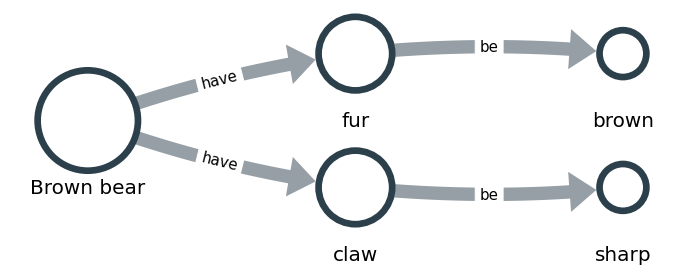

In [31]:
kg = [
    ('Brown bear', 'have', 'claw'),
    ('Brown bear', 'have', 'fur'),
    ('fur', 'be', 'brown'),
    ('claw', 'be', 'sharp'),
]

df = pd.DataFrame(kg, columns=['source', 'edge', 'target'])

G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

fig, ax = plt.subplots(figsize=(12, 6))
#plt.figure(figsize=(8, 3))
labels = dict(zip(list(zip(df.source, df.target)),
                  df['edge'].tolist()))

node_size = {
    'Brown bear': 4,
    'fur': 3,
    'claw': 3,
    'sharp': 2,
    'brown': 2,
}

node_color = {
    'Brown bear': 'white',
    'fur': 'white',
    'claw': 'white',
    'sharp': 'white',
    'brown': 'white',    
}

fixed = {
    'Brown bear': np.array([0, 0.5]),
    'fur': np.array([.2, .55]),
    'claw': np.array([.2, .45]),
    'sharp': np.array([.4, .45]),
    'brown': np.array([.4, .55]),
}

node_labels = {node : node for node in G}


Graph(G, node_labels=node_labels, edge_layout='curved', arrows=True,
      node_layout=pos, node_size=node_size, node_color=node_color, edge_labels=labels,
     node_label_offset=(0.00, -0.05),
           node_label_fontdict=dict(size=20),
      edge_label_fontdict=dict(size=15),)
plt.savefig('kn_example_v2.pdf', format='pdf', dpi=1200, bbox_inches='tight')



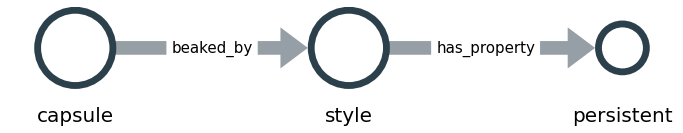

In [8]:
kg = [
    ('capsule', 'beaked_by', 'style'),
    ('style', 'has_property', 'persistent'),
]

df = pd.DataFrame(kg, columns=['source', 'edge', 'target'])

G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

fig, ax = plt.subplots(figsize=(12, 6))
#plt.figure(figsize=(8, 3))
labels = dict(zip(list(zip(df.source, df.target)),
                  df['edge'].tolist()))

node_size = {
    'capsule': 3,
    'style': 3,
    'persistent': 2,
}

node_color = {
    'capsule': 'white',
    'style': 'white',
    'persistent': 'white',
}

fixed = {
    'capsule': np.array([0, 0.5]),
    'style': np.array([.2, .5]),
    'persistent': np.array([.4, .5]),
}

node_labels = {node : node for node in G}


Graph(G, node_labels=node_labels, edge_layout='curved', arrows=True,
      node_layout=fixed, node_size=node_size, node_color=node_color, edge_labels=labels,
     node_label_offset=(0.00, -0.05),
           node_label_fontdict=dict(size=20),
      edge_label_fontdict=dict(size=15),)
plt.savefig('kn_discussion_example.pdf', format='pdf', dpi=1200, bbox_inches='tight')



In [ ]:
from spacy import displacy
import spacy
nlp = spacy.load('en_core_web_trf')

In [ ]:
svg = displacy.render(nlp('The Brown bear has brown fur.'), style="dep", jupyter=False,
               options={'compact': False,
                        'distance': 100,
                        'arrow_stroke': 2,
                        'arrow_spacing': 9})

with open("PoS_example.svg", "w") as f:
    f.write(svg)
    
svg = displacy.render(nlp('The claws are sharp.'), style="dep", jupyter=False,
               options={'compact': False,
                        'distance': 100,
                        'arrow_stroke': 2,
                        'arrow_spacing': 9})

with open("PoS_example2.svg", "w") as f:
    f.write(svg)

In [ ]:
kg = [
    ('Brown bear', 'has part', 'claw'),
    ('Brown bear', 'has part', 'fur'),
    ('fur', 'has color', 'brown'),
    ('fur', 'has property', 'thick'),
    ('claw', 'part part', 'nail'),
    ('claw', 'has property', 'large'),
    ('claw', 'has similar name', 'paw'),
    ('nail', 'has property', 'sharp'),
    ('nail', 'has measurement', '5'),
    ('Brown bear', 'has part', 'nose'),
    ('nose', 'similar as', 'Black bear'),
    ('Black bear', 'has part', 'nose '),
    ('nose ', 'has color', 'black'),
]


df = pd.DataFrame(kg, columns=['source', 'edge', 'target'])

G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

#plt.figure(figsize=(8, 3))
labels = dict(zip(list(zip(df.source, df.target)),
                  df['edge'].tolist()))

node_size = {
    'Brown bear': 4,
    'Black bear': 4,
    'fur': 3,
    'nose': 3,
    'nose ': 3,
    'claw': 3,
    'nail': 3,
    'thick': 2,
    '5': 2,
    'sharp': 2,
    'brown': 2,
    'paw': 3,
    'large': 2,
    'black': 2
}

node_color = {
    'Brown bear': 'darkgreen',
    'Black bear': 'darkgreen',
    'fur': 'lightgreen',
    'claw': 'lightgreen',
    'sharp': 'white',
    'brown': 'white', 
    'thick': 'white',
    'nail': 'lightgreen',
    '5': 'white',
    'large': 'white',
    'paw': 'lightgreen',
    'nose': 'lightgreen',
    'nose ': 'lightgreen',
    'black': 'white',
}

node_labels = {node : node for node in G}
fig, ax = plt.subplots(figsize=(25, 25))
Graph(G, node_layout='dot', edge_layout='curved', 
      node_size=node_size, node_labels=node_labels, node_color=node_color,
      edge_labels=labels, node_label_offset=(0.00, -0.05), 
     node_label_rotate=50, arrows=True, edge_width=.7,
      node_label_fontdict=dict(size=20),
      edge_label_fontdict=dict(size=15),
     ax=ax)

#plt.savefig('kngraph_rec.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
kg = [
    ('European robin', 'has part', 'Eye'),
    ('European robin', 'has part', 'Plumage'),
    ('European robin', 'has part', 'Neck'),
    ('European robin', 'has part', 'Leg'),
    ('European robin', 'has part', 'Bill'),
    ('Eye', 'has property', 'Black'),
    ('Plumage', 'has property', 'Orange'),
    ('Neck', 'has property', 'Bluish Grey'),
    ('Leg', 'has property', 'Grey'),
    ('Bill', 'has property', 'Black'),
]


df = pd.DataFrame(kg, columns=['source', 'edge', 'target'])

G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

#plt.figure(figsize=(8, 3))
labels = dict(zip(list(zip(df.source, df.target)),
                  df['edge'].tolist()))

node_size = {
    'European robin': 4,
    'European robin': 4,
    'Leg': 3,
    'Bill': 3,
    'Eye': 3,
    'Plumage': 3,
    'Neck': 3,
    'Black': 2,
    'Bluish Grey': 2,
    'Grey': 2,
    'Orange': 2,
}

node_color = {
    'European robin': 'darkgreen',
    'Leg': 'lightgreen',
    'Bill': 'lightgreen',
    'Eye': 'lightgreen',
    'Neck': 'lightgreen',
    'Plumage': 'lightgreen',
    'Black': 'white',
    'Bluish Grey': 'white', 
    'Grey': 'white',
    'Orange': 'white',
}

pos = nx.spring_layout(G, k = 0.015, iterations=5000, seed=1, dim=2,scale=0.8, center=(0,0))

node_labels = {node : node for node in G}
fig, ax = plt.subplots(figsize=(25, 25))
Graph(G, node_layout=pos, edge_layout='straight', 
      node_size=node_size, node_labels=node_labels, node_color=node_color,
      edge_labels=labels, node_label_offset=(0.00, -0.05), 
     node_label_rotate=50, arrows=True, edge_width=.7,
      node_label_fontdict=dict(size=20),
      edge_label_fontdict=dict(size=15),
      node_layout_kwargs=dict(total_iterations=100, seed=33, k = 0.0005),
      #node_layout_kwargs=dict(node_size=1, total_iterations=20),
     ax=ax)

#plt.savefig('kngraph_rec.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from scipy import stats

In [ ]:
logstack = np.load('../data/plotting/logstack.npy')
probstack = np.load('../data/plotting/probstack.npy')
logprobs = np.load('../data/plotting/logprobs.npy')

In [ ]:
TRAIN = pickle.load(open('../data/processed/RDF_TEXT_TRAIN_SET_554.pkl', 'rb'))
TEST = pickle.load(open('../data/processed/RDF_TEXT_TEST_SET_554.pkl', 'rb'))

In [ ]:
lb = LabelBinarizer()
keys = np.array([key for key in TRAIN.keys()])
keys_encoded = lb.fit_transform(keys)

In [ ]:
plant_idx = 2
species = list(TRAIN.keys())
plant = species[plant_idx]

In [ ]:
logprobs.shape

In [ ]:
#sns.set_style('whitegrid')
fig, (probs, logs) = plt.subplots(2, sharex=True,
                                    gridspec_kw={"height_ratios": (.5, .5)},
                                    figsize=(10, 6))

for i in range(0, len(species)):
    if i == np.where(lb.classes_ == plant)[0][0]:
        probs.plot(np.exp(logprobs[:, i]), color='blue', alpha=1, markersize=5, zorder=2)
        logs.plot(logprobs[:, i], color='blue', alpha=1, markersize=5, zorder=2)
    else:
        probs.plot(np.exp(logprobs[:, i]), color='red', alpha=0.1, zorder=1)
        logs.plot(logprobs[:, i], color='red', alpha=0.1, zorder=1)
        
probs.set_ylim([-0.05, 1.05])
probs.set_xlim([-0.5, logprobs.shape[0] -0.5])
probs.set(ylabel="Probabilities")
logs.set(ylabel="Negative Log Values", xlabel='Sentence')
#fig.align_ylabels((probs, logs))
probs.yaxis.set_label_coords(-0.08, 0.5)
logs.yaxis.set_label_coords(-0.08, 0.5)

legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Correct Species', linestyle='solid'),
                   Line2D([0], [0], color='red', alpha=0.5, lw=2, label='Incorrect Species', linestyle='solid')]

probs.legend(handles=legend_elements, loc='upper right')
plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../data/plotting/probs_nonstacked.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
#sns.set_style('whitegrid')
fig, (probs, logs) = plt.subplots(2, sharex=True,
                                    gridspec_kw={"height_ratios": (.5, .5)},
                                    figsize=(10, 6))

for i in range(0, len(species)):
    if i == np.where(lb.classes_ == plant)[0][0]:
        probs.plot(probstack[:, i], color='blue', alpha=1, markersize=5, zorder=2)
        logs.plot(logstack[:, i], color='blue', alpha=1, markersize=5, zorder=2)
    else:
        probs.plot(probstack[:, i], color='red', alpha=0.1, zorder=1)
        logs.plot(logstack[:, i], color='red', alpha=0.1, zorder=1)
        
probs.set_ylim([-0.05, 1.05])
probs.set_xlim([-0.5, logprobs.shape[0] -0.5])
probs.set(ylabel="Summed Probabilities")
logs.set(ylabel="Summed Negative Log Values", xlabel='Sentence')
#fig.align_ylabels((probs, logs))

probs.yaxis.set_label_coords(-0.08, 0.5)
logs.yaxis.set_label_coords(-0.08, 0.5)

legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Correct Species', linestyle='solid'),
                   Line2D([0], [0], color='red', alpha=0.5, lw=2, label='Incorrect Species', linestyle='solid')]

logs.legend(handles=legend_elements, loc='lower left')
plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../data/plotting/probs_stacked.pdf', format='pdf', dpi=50, bbox_inches='tight')

In [ ]:
correct = np.load('../data/plotting/model_pred_correct.npy')
incorrect = np.load('../data/plotting/model_pred_incorrect.npy')

In [ ]:

print(stats.mannwhitneyu(correct, incorrect, alternative='greater'))

print(stats.wilcoxon(correct, incorrect, alternative='greater'))

d = {'Correct': correct, 'Incorrect': incorrect}
df = pd.DataFrame(dict([ (k, pd.Series(v)) for k, v in d.items() ]))
df_m = df.melt()

#fig, ax = plt.subplots(figsize=(10, 6))
#sns.set_style('whitegrid')

#sns.violinplot(x="value", y="variable", data=df_m[df_m.value > -12000], 
#               showfliers=False, ax=ax, split=True, cut=0, inner="box", bw=.2)


#sns.ecdfplot(data=df_m[df_m.value > -3500], x="value", hue="variable")


In [ ]:
BOW = pickle.load(open('../data/processed/train_dataBOW.pkl', 'rb'))
WIK = pickle.load(open('../data/processed/train_dataWIKI_all.pkl', 'rb'))
POW = pickle.load(open('../data/processed/train_dataPOWO.pkl', 'rb'))

In [ ]:
#WIK['Razorbill']

In [ ]:
len(WIK.keys()) + len(BOW.keys()) + len(POW.keys())